# On the properties of variational approximations of Gibbs posteriors

##### Authors : Pierre Alquier, James Ridgway, Nicolas Chopin

##### Notebook created by Adrien Letellier \& Augustin Cablant 

[Article](https://arxiv.org/pdf/1506.04091)

### 1) **Introduction**
   - Overview of the context and objectives of the study.

### 2) **Framework**
   - Explanation of the theoretical framework and methods used in the paper.

### 3) **Assumptions**
   - Details of the underlying assumptions, including those of Bernstein and Hoeffding.

### 4) **Numerical approximations of the pseudo posterior**
   - Discussion on the numerical approximations of the pseudo-posterior, including:
     - Tempering SMC
     - Variational Bayes

### 5) **Applications**
   - a) Classification
   - b) [Other application to be detailed]

### 6) **Conclusion**
   - Summary of key conclusions and future directions.

In [21]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
from numpy.linalg import eigvals
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.optimize import bisect
from functools import partial
from SMC import Tempering_SMC
np.random.seed(2025)

# Introduction

 The Gibbs posterior (or pseudo-posterior $\hat{\rho _{\lambda}}$) is defined for all $\lambda > 0$ as : 
 
 $$\hat{\rho _{\lambda}} (\theta) \propto \exp\left(-\lambda r_n (\theta)\right) \pi(\theta), $$

where:

- $r_n( \theta )$ is an empirical measure of risk

- $\pi(\theta)$ is the prior.

> Estimators derived from Gibbs posteriors usually show excellent performance in diverse tasks, such as classification, regression, ranking. Usually, we sample from a Gibbs posterior using MCMC, but constructing an efficient MCMC sampler is often difficult. Instead we use VB (Variational Bayes) approximations.

# Framework

We observe a sample $(X_1, Y_1), \dots, (X_n, Y_n)$, taking values in $\mathcal{X} \times \mathcal{Y}$, where the pairs $(X_i, Y_i)$ have the same distribution $P$. We will assume explicitly that the $(X_i, Y_i)$’s are independent. 

A set of predictors is chosen by the statistician: 
$$
\{f_\theta : \mathcal{X} \to \mathbb{R}, \theta \in \Theta\}.
$$
For example, in linear regression, we may have: $f_\theta(x) = \langle \theta, x \rangle$, the inner product of $\mathcal{X} = \mathbb{R}^d$, while in classification, one may have $f_\theta(x) = \mathbb{I}_{\langle \theta, x \rangle > 0} \in \{0, 1\}$.

We assume we have at our disposal a risk function $R(\theta)$; typically $R(\theta)$ is a measure of the prevision error. We set $R = R(\theta)$, where 
$$
\theta \in \arg \min_\Theta R(\theta);
$$ 
i.e. $f_\theta$ is an optimal predictor. We also assume that the risk function $R(\theta)$ has an empirical counterpart $r_n(\theta)$, and set $r_n = r_n(\theta)$. 

Often, $R$ and $r_n$ are based on a loss function $l : \mathbb{R}^2 \to \mathbb{R}$; i.e. 
$$
R(\theta) = \mathbb{E}[l(Y, f_\theta(X))] \quad \text{and} \quad r_n(\theta) = \frac{1}{n} \sum_{i=1}^n l(Y_i, f_\theta(X_i)).
$$
(In this paper, the symbol $\mathbb{E}$ will always denote the expectation with respect to the (unknown) law $P$ of the $(X_i, Y_i)$’s.) There are situations however (e.g. ranking), where $R$ and $r_n$ have a different form.

We define a prior probability measure $\pi(\cdot)$ on the set $\Theta$ (equipped with the standard $\sigma$-algebra for the considered context), and we let $\mathcal{M}_1^+(\Theta)$ denote the set of all probability measures on $\Theta$.


# Assumptions 

## Hoeffding assumption

We say that a **Hoeffding assumption** is satisfied for prior $ \pi $ when there is a function $ f $ and an interval $ I \subset \mathbb{R}_+^* $ such that, for any $ \lambda \in I $, for any $ \theta \in \Theta $,

$$ \frac{\pi \left( \mathbb{E} \exp \{ \lambda [R(\theta) - r_n(\theta)] \} \right)}{\pi \left( \mathbb{E} \exp \{ \lambda [r_n(\theta) - R(\theta)] \} \right)} 
\leq \exp \big[ f(\lambda, n) \big]. \tag{1} $$

$\quad $

## Bernstein assumption

We say that a Bernstein assumption is satisfied for prior $\pi$ when there is a function $g$ and an interval $I \subset \mathbb{R}_+^*$ such that, for any $\lambda \in I$, for any $\theta \in \Theta$,
$$
\frac{\pi \left( \mathbb{E} \exp \left\{ \lambda [R(\theta) - R^*] - \lambda [r_n(\theta) - r_n^*] \right\} \right)}
{\pi \left( \mathbb{E} \exp \left\{ \lambda [r_n(\theta) - r_n^*] - \lambda [R(\theta) - R^*] \right\} \right)} 
\leq \pi \exp \big[ (g(\lambda, n))  [R(\theta) - R^*] \big].
\tag{2}
$$

Assume that **Mammen and Tsybakov’s** margin assumption is satisfied: i.e., there is a constant $C$ such that
$$
\mathbb{E} \left[ \big( \mathbf{1}_{f_\theta(X) \neq Y} - \mathbf{1}_{f_{\theta^*}(X) \neq Y} \big)^2 \right] 
\leq C \big[ R(\theta) - R(\theta^*) \big].
$$

# Numerical approximations of the pseudo-posterior

The usual approach to approximate $\hat{\rho}_\lambda$ is MCMC (Markov chain Monte Carlo) sampling. Ridgway et al. [2014] proposed tempering SMC (Sequential Monte Carlo, e.g. Del Moral et al. [2006]) as an alternative to MCMC to sample from Gibbs posteriors: one samples sequentially from $\hat{\rho}_{\lambda_t}$, with $0 = \lambda_0 < \cdots < \lambda_T = \lambda$ where $\lambda$ is the desired temperature. One advantage of this approach is that it makes it possible to contemplate different values of $\lambda$, and choose one by, e.g., cross-validation. Another advantage is that such an algorithm requires little tuning; see Appendix B for more details on the implementation of tempering SMC. We will use tempering SMC as our gold standard in our numerical studies.

SMC and related Monte Carlo algorithms tend to be too slow for practical use in situations where the sample size is large, the dimension of $\Theta$ is large, or $f_\theta$ is expensive to compute. This motivates the use of fast, deterministic approximations, such as Variational Bayes, which we describe in the next section.

---

## Algorithm 1: Tempering SMC
1. **Input**: $N$ (number of particles), $\tau \in (0, 1)$ (ESS threshold), $\kappa > 0$ (random walk tuning parameter)
2. **Initialization**: Sample $\theta_0^i \sim \pi_\xi(\theta)$ for $i = 1$ to $N$, set $t \gets 1$, $\lambda_0 = 0$, $Z_0 = 1$.
3. **Loop**:
   a. Solve in $\lambda_t$ the equation:
   $$
   \frac{\left(\sum_{i=1}^N w_t(\theta_{t-1}^i)\right)^2}{\sum_{i=1}^N w_t(\theta_{t-1}^i)^2} = \tau N, \quad w_t(\theta) = \exp\left[-(\lambda_t - \lambda_{t-1}) r_n(\theta)\right]
   $$
   using bisection search.  
   If $\lambda_t \geq \lambda_T$:
   - Set $Z_T = Z_{t-1} \times \left(\frac{1}{N} \sum_{i=1}^N w_t(\theta_{t-1}^i)\right)$, and stop.

   b. **Resample**: For $i = 1$ to $N$, draw $A_t^i$ in $\{1, \ldots, N\}$ so that:
   $$
   \Pr(A_t^i = j) = \frac{w_t(\theta_{t-1}^j)}{\sum_{k=1}^N w_t(\theta_{t-1}^k)}.
   $$

   c. **Propagate**: $\theta_t^i \gets \text{Perturb}(\theta_{t-1}^{A_t^i})$.

   d. Set:
   $$
   Z_t = Z_{t-1} \times \left(\frac{1}{N} \sum_{i=1}^N w_t(\theta_{t-1}^i)\right).
   $$

---

### Algorithm 2: Systematic Resampling
1. **Input**: Normalized weights $W_j := \frac{w_t(\theta_j)}{\sum_{i=1}^N w_t(\theta_i)}$.
2. **a.** Sample $U \sim \mathcal{U}([0, 1])$.
3. **b.** Compute cumulative weights as $C_n = \sum_{m=1}^n N W_m$.
4. **c.** Set $s \gets U$, $m \gets 1$.
5. **d.** For $n = 1$ to $N$:
   - While $C_m < s$:
     - $m \gets m + 1$.
   - Set $A_n \gets m$, $s \gets s + 1$.

In [ ]:
### First we implement systematic resampling as defined in algorithm 2 of the paper. ###
def systematic_resampling(W):
    """
    Perform systematic resampling given a set of normalized weights.

    Args:
        W (numpy.ndarray): Array of normalized weights.
        W_t (float): Normalized weights of the current time step, size N.

    Returns:
       A (numpy.ndarray) : Indices of resampled particles.
    """
    N = len(W)
    U = np.random.uniform(0, 1)  # Step a: Sample U ~ U([0, 1])
    cumulative_weights = N * np.cumsum(W)  # Step b: Compute cumulative weights

    # Step c: Initialize variables
    s = U
    m = 1
    A = []
    # Step d: Resample
    for n in range(1, N + 1):
        while s > cumulative_weights[m]:
            m += 1
        A.append(m)
        s += 1 
    return np.array(A)


### Next we implement the SMC algorithm as defined in algorithm 1 of the paper. ###
def Tempering_SMC(N, tau, kappa, target_distribution, initial_distribution, likelihood_ratio):
    """ Perform the Tempering Sequential Monte Carlo (SMC) algorithm for Bayesian inference.

    Parameters
    ----------
    N : int
    Number of particles to use in the SMC algorithm.

    tau : float
        ESS threshold for resampling.

    rw : positive
        random walk tuning parameter.

    kappa : float
        Random walk tuning parameter.

    target_distribution : callable
        Target distribution function  pi

    initial_distribution : callable
        Initial distribution function pi_xi

    likelihood_ratio : callable
        Function computing r_n(theta)

    Returns:
    ----------
    list: List of particle states at each iteration. 
    """ 
    
    theta = [initial_distribution() for _ in range(N)]
    t = 1
    lambda_t = 0
    Z = 1
    results = []

    def program_bisec(lambd):
        w = np.exp(- (lambd - lambda_t) * np.array([likelihood_ratio(p) for p in theta]))
        ratio = (np.sum(w) ** 2) / np.sum(w ** 2)
        return ratio - N * tau
    
    while True:
        # Step a: Solve for new lambda_t using bisection 
        lambda_new = bisect(program_bisec, lambda_t, 1)
        w = np.exp(- (lambda_new - lambda_t) * np.array([likelihood_ratio(p) for p in theta]))
        if lambda_new <= lambda_t:
            break 

        # Step b: Resample
        normalized_weights = w / np.sum(w)  
        A = systematic_resampling(normalized_weights)
        theta = [theta[a] for a in A]

        # Step c: MCMC step (Gaussian random-walk Metropolis kernel)
        cov = kappa * np.cov(np.array(theta).T)
        for i in range(N):
            proposal = theta[i] + np.random.multivariate_normal(np.zeros(len(theta[0])), cov)
            accept_ratio = min(1, target_distribution(proposal) / target_distribution(theta[i]))
            if np.random.uniform() < accept_ratio:
                theta[i] = proposal

    
        # Step d: Update normalizing constant Z
        Z *= np.mean(w)
        results.append((theta.copy(), Z))
 
    return results

## Variational Bayes

Variational Bayes (VB) is an approach to approximate $\hat{\rho}_\lambda$ by defining a family $\mathcal{F} \subset \mathcal{M}_1^+(\Theta)$ of tractable probability distributions. The VB approximation $\tilde{\rho}_\lambda$ is defined as:  
$$
\tilde{\rho}_\lambda = \arg\min_{\rho \in \mathcal{F}} K(\rho, \hat{\rho}_\lambda),
$$  
where $K(\rho, \hat{\rho}_\lambda)$ is the Kullback-Leibler (KL) divergence, defined as:  
$$
K(m, \mu) = 
\begin{cases} 
\int \log\left(\frac{dm}{d\mu}\right) dm & \text{if } m \ll \mu, \\
+\infty & \text{otherwise}.
\end{cases}
$$

The choice of $\mathcal{F}$ must balance two criteria:  
(a) $\mathcal{F}$ should be large enough for $\tilde{\rho}_\lambda$ to closely approximate $\hat{\rho}_\lambda$,  
(b) $\mathcal{F}$ should allow efficient computation of $\tilde{\rho}_\lambda$.  


$ \quad $

# Applications 

## Classification

In all this section, we assume that $ Y = \{0, 1\} $ and we consider linear classification: $ \Theta = X = \mathbb{R}^d $, $ f_\theta(x) = \mathbf{1}_{\langle \theta, x \rangle \geq 0} $. We put 

$$r_n(\theta) = \frac{1}{n} \sum_{i=1}^n \mathbf{1}\{f_\theta(X_i) \neq Y_i\}, \quad R(\theta) = \mathbb{P}(Y \neq f_\theta(X)), $$

and assume that the $(X_i, Y_i)_{i=1}^n $ are i.i.d.
In this setting, it is well-known that the Hoeffding assumption always holds. That's to say:


### Hoeffding assumption

We say that a **Hoeffding assumption** is satisfied for prior $ \pi $ when there is a function $ f $ and an interval $ I \subset \mathbb{R}_+^* $ such that, for any $ \lambda \in I $, for any $ \theta \in \Theta $,

$$ \frac{\pi \left( \mathbb{E} \exp \{ \lambda [R(\theta) - r_n(\theta)] \} \right)}{\pi \left( \mathbb{E} \exp \{ \lambda [r_n(\theta) - R(\theta)] \} \right)} 
\leq \exp \big[ f(\lambda, n) \big]. \tag{1} $$

Here, Hoeffding assumption is satisfied with $f(\lambda, n) = \frac{\lambda^2}{2n}$.

### Bernstein assumption

We say that a Bernstein assumption is satisfied for prior $\pi$ when there is a function $g$ and an interval $I \subset \mathbb{R}_+^*$ such that, for any $\lambda \in I$, for any $\theta \in \Theta$,
$$
\frac{\pi \left( \mathbb{E} \exp \left\{ \lambda [R(\theta) - R^*] - \lambda [r_n(\theta) - r_n^*] \right\} \right)}
{\pi \left( \mathbb{E} \exp \left\{ \lambda [r_n(\theta) - r_n^*] - \lambda [R(\theta) - R^*] \right\} \right)} 
\leq \pi \exp \big[ (g(\lambda, n))  [R(\theta) - R^*] \big].
\tag{2}
$$

Assume that **Mammen and Tsybakov’s** margin assumption is satisfied: i.e., there is a constant $C$ such that
$$
\mathbb{E} \left[ \big( \mathbf{1}_{f_\theta(X) \neq Y} - \mathbf{1}_{f_{\theta^*}(X) \neq Y} \big)^2 \right] 
\leq C \big[ R(\theta) - R(\theta^*) \big].
$$
Then Bernstein assumption is satisfied with 
$$
g(\lambda, n) = \frac{C \lambda^2}{2n - \lambda}.
$$

### The prior 

Gaussian prior : $ \pi = \mathcal{N}_d (0, v^2 \text{I}_d )$.

### Three sets of Variational Gaussian approximations:  
Consider the three following Gaussian families 
$$
\mathcal{F}_1 = \{ \Phi_{m, \sigma^2} \mid m \in \mathbb{R}^d, \sigma^2 \in \mathbb{R}_+^* \},
$$
$$
\mathcal{F}_2 = \{ \Phi_{m, \sigma^2} \mid m \in \mathbb{R}^d, \sigma^2 \in (\mathbb{R}_+^*)^d \},
$$
$$
\mathcal{F}_3 = \{ \Phi_{m, \Sigma} \mid m \in \mathbb{R}^d, \Sigma \in \mathcal{S}_d^+ \},
$$
where $\Phi_{m, \sigma^2}$ is a Gaussian distribution $\mathcal{N}_d(m, \sigma^2 I_d)$, $\Phi_{m, \sigma^2}$ is $\mathcal{N}_d(m, \text{diag}(\sigma^2))$, and $\Phi_{m, \Sigma}$ is $\mathcal{N}_d(m, \Sigma)$. 

Obviously, $\mathcal{F}_1 \subset \mathcal{F}_2 \subset \mathcal{F}_3 \subset \mathcal{M}_1^+(\Theta)$, and
$$
B_\lambda(\mathcal{M}_1^+(\Theta)) \leq B_\lambda(\mathcal{F}_3) \leq B_\lambda(\mathcal{F}_2) \leq B_\lambda(\mathcal{F}_1).
$$


In [2]:
def L_F2(m, sigma2, X, y, lmbda, nu):
    """ 
    Variational lower bound for mean field family, as defined page 11 (section 5.4)
    Evaluated for given m, sigma2
    """
    n, d = X.shape

    first_sum = 0
    for i in range(n):
        first_sum += stats.norm.cdf( -y[i] * ( X[i] @ m / np.sqrt( X[i] @ np.diag(sigma2) @ X[i].T ) ) )
    second_sum = 0
    for k in range(d):
        second_sum += np.log(sigma2[k]) - (sigma2[k]/nu)
        
    return -(lmbda/n)*first_sum - (m.T @ m)/(2*nu) + 0.5*second_sum

def L_F3(m, Sigma, X, y, lmbda, nu):
    """ 
    Variational lower bound for full covariance family, as defined page 11 (section 5.4)
    Evaluated for given m, Sigma
    """
    n, d = X.shape

    first_sum = 0
    for i in range(n):
        first_sum += stats.norm.cdf( -y[i] * ( X[i] @ m / np.sqrt( X[i] @ Sigma @ X[i].T ) ) )
        
    return -(lmbda/n)*first_sum - (m.T @ m)/(2*nu) + 0.5*(np.log(np.linalg.det(Sigma)) - (1/nu)*np.trace(Sigma))

def vec_to_lower_triangular(x, n):
    """Convert vector to lower triangular matrix."""
    L = np.zeros((n, n))
    idx = 0
    for i in range(n):
        for j in range(i + 1):
            if i == j:
                L[i, j] = np.exp(x[idx])  # Diagonal elements are exp(x)
            else:
                L[i, j] = x[idx]  # Off-diagonal elements unchanged
            idx += 1
    return L

def lower_triangular_to_vec(L):
    """Convert lower triangular matrix to vector."""
    n = L.shape[0]
    x = []
    for i in range(n):
        for j in range(i + 1):
            if i == j:
                x.append(np.log(L[i, j]))  # Log of diagonal elements
            else:
                x.append(L[i, j])
    return np.array(x)

def logCholesky_L_F3(m, L, X, y, lmbda, nu): # L is a vector
    """ 
    Variational lower bound for full covariance family, as defined page 11 (section 5.4)
    Evaluated for given m, L, with L the vector of the log-Cholesky parametrization
    """
    n, d = X.shape
    L = vec_to_lower_triangular(L, d)
    Sigma = L @ L.T  # Reconstruct positive definite matrix

    return L_F3(m, Sigma, X, y, lmbda, nu)

### Algorithm 3: Deterministic Annealing

#### Input  
- $(\lambda_t)_{t \in [0, T]}$: Sequence of temperatures.

#### Initialization  
- Set $m = 0$ and $\Sigma = \theta I_d$, the values minimizing the KL-divergence for $\lambda = 0$.

#### Main Loop  
For $t = 1, \dots, T$:  
1. Update $m_{\lambda_t}, \Sigma_{\lambda_t}$ by minimizing the objective function $L_{\lambda_t}(m, \Sigma)$ using a local optimization routine.  
   - Start from the initial values $m_{\lambda_{t-1}}, \Sigma_{\lambda_{t-1}}$.  
2. Stop the loop if the empirical bound increases.  

#### Output  
The final values of $m_{\lambda_t}$ and $\Sigma_{\lambda_t}$.  


In [3]:
class DeterministicAnnealing():
    def __init__(self, temperatures, patience, X, y, nu=None, verbose=False):
        self.temperatures = temperatures
        self.patience = patience
        self.verbose = verbose
        self.X = X
        self.n, self.d = X.shape
        self.y = y
        if not nu:
            self.nu = self.d / (self.d + 2 + 2*self.d/self.n)
        else:
            self.nu = nu

    # Peut-être faire un train et un test ou une cross validation pour calculer l'empirical bound de manière plus réaliste ???

    def compute_empirical_bound(self, m, sigma2, lmbda, epsilon, n_examples=1000):
        # First get an approximation of the integrated risk
        ypred = []
        ytrue = []
        for _ in range(n_examples):
            i = np.random.randint(0, self.n)
            beta = stats.multivariate_normal(mean=m, cov=np.diag(sigma2)).rvs()
            ypred.append(0.5 * (np.sign(self.X[i] @ beta) + 1))
            ytrue.append(self.y[i])
        ypred = np.array(ypred)
        ytrue = np.array(ytrue)
        empirical_risk = np.mean(ypred != ytrue)
        # print(empirical_risk)

        # Compute the numerator of the last term
        numerator = np.sum([0.5*np.log(self.nu**2 / sigma2[i]**2) + sigma2[i]**2 / self.nu**2 for i in range(self.d)]) + m@m / self.nu**2 - d/2 + np.log(1/epsilon)
        return empirical_risk + lmbda/(2*self.n) + (1/lmbda)*numerator

    def run_F2(self):
        # Init
        m_t = np.zeros(self.d)
        sigma2_t = self.nu*np.ones(self.d)
        params_t = np.concatenate([m_t, sigma2_t], axis=0)
        value_t = L_F2(params_t[:self.d], params_t[self.d:], self.X, self.y, 0, self.nu) # max L_F2    
        # print(value_t)
        # empirical_bound_t = self.compute_empirical_bound(m_t, sigma2_t, 0, 0.05)
        # print(empirical_bound_t)
        empirical_bound_star = np.inf

        # Loop
        p = 0 # patience counter
        for ix, lmbda_t in enumerate(self.temperatures):
            if self.verbose:
                print(lmbda_t)
            # a)
            params_prev = params_t.copy()
            objective_t = lambda params: - L_F2(params[:self.d], params[self.d:], self.X, self.y, lmbda_t, self.nu)
            bounds = [(None, None)]*self.d + [(0, None)]*self.d
            results = minimize(
                objective_t, 
                params_prev, 
                method='L-BFGS-B',
                bounds = bounds
            )
            params_t = results.x
            # value_t = - results.fun
            # print(value_t)
            m_t = params_t[:self.d]
            sigma2_t = params_t[self.d:]
            empirical_bound_t = self.compute_empirical_bound(m_t, sigma2_t, lmbda_t, 0.05)
            if self.verbose:
                print(empirical_bound_t)
            # b)
            if empirical_bound_t > empirical_bound_star:
                p += 1
                if p == self.patience:
                    return m_star, sigma2_star, empirical_bound_star, lmbda_star
            else:
                p = 0
                m_star, sigma2_star, empirical_bound_star, lmbda_star = m_t.copy(), sigma2_t.copy(), empirical_bound_t, lmbda_t
        return m_t, sigma2_t, empirical_bound_t, lmbda_t

    def run_F3(self, lmbda_star_F2):
        # Init
        m_t = np.zeros(self.d)
        L_t = np.sqrt(self.nu)*np.eye(self.d)
        # print(self.nu)
        logCholesky_L_t = lower_triangular_to_vec(L_t)
        # print(L_t)
        # print(vec_to_lower_triangular(logCholesky_L_t, self.d))
        Sigma_t = L_t @ L_t.T
        # print(Sigma_t) # vérifier qu'on retrouve le bon
        params_t = np.concatenate([m_t, logCholesky_L_t], axis=0)
        value_t = logCholesky_L_F3(m_t, logCholesky_L_t, self.X, self.y, 0, self.nu)
        empirical_bound_t = np.inf      

        # Loop
        p = 0
        for ix, lmbda_t in enumerate(self.temperatures):
            if self.verbose:
                print(lmbda_t)
            # a)
            params_prev = params_t.copy()
            # il faut faire la reparamétrisatiion
            objective_t = lambda params: - logCholesky_L_F3(params[:self.d], params[self.d:], self.X, self.y, lmbda_t, self.nu)
            result = minimize(
                fun=objective_t,
                x0=params_prev,
                method='L-BFGS-B'
            )
            params_t = result.x
            # value_t = - result.fun
            m_t = params_t[:self.d]
            L_t = vec_to_lower_triangular(params_t[self.d:], self.d)
            Sigma_t = L_t @ L_t.T
             # b)
            if lmbda_t == lmbda_star_F2:
                return m_t, Sigma_t

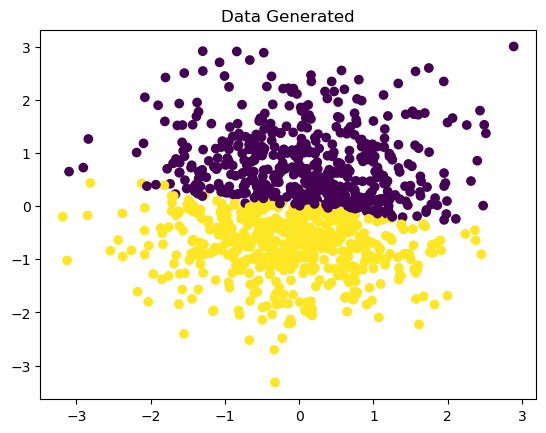

/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_6604/4038806100.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  first_sum += stats.norm.cdf( -y[i] * ( X[i] @ m / np.sqrt( X[i] @ np.diag(sigma2) @ X[i].T ) ) )
/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_6604/4038806100.py:10: RuntimeWarning: invalid value encountered in scalar multiply
  first_sum += stats.norm.cdf( -y[i] * ( X[i] @ m / np.sqrt( X[i] @ np.diag(sigma2) @ X[i].T ) ) )
/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_6604/4038806100.py:13: RuntimeWarning: divide by zero encountered in log
  second_sum += np.log(sigma2[k]) - (sigma2[k]/nu)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
100%|██████████| 1000/1000 [00:00<00:00, 14524.72it/s]

Missclassification rate:  0.043


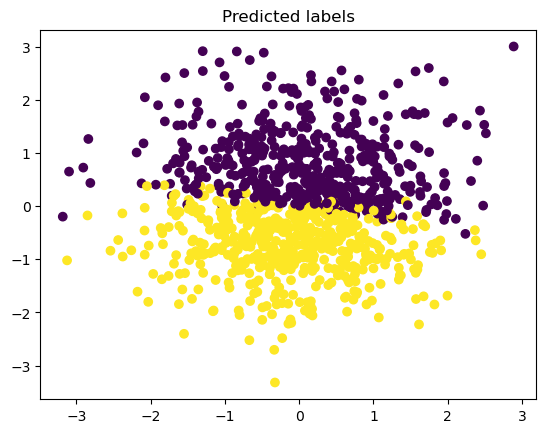

In [7]:
# Example 
## We generate some data
n, d = 1000, 2
X = np.random.randn(n, d)
true_w = np.random.randn(d)
y = 0.5 * (np.sign(X @ true_w + 0.1 * np.random.randn(n)) + 1)
# Plot the data 
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Data Generated")
plt.show()

# perform the DA
temperatures = list(range(10, 500, 10))
DA = DeterministicAnnealing(temperatures = temperatures, 
                            patience = 5, 
                            X = X, 
                            y = y, 
                            verbose = False)
m_F2, sigma2_F2, _, lmbda_star_F2 = DA.run_F2()
m_F3, Sigma_F3 = DA.run_F3(lmbda_star_F2)

ypred = []
for i in tqdm(range(len(X))):
    beta = stats.multivariate_normal(mean = m_F2, cov = np.diag(sigma2_F2)).rvs()
    ypred.append(0.5 * (np.sign(X[i] @ beta) + 1))
    
# Missclassification rate
print("Missclassification rate: ", np.mean(ypred != y))

# Plot the data
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c = ypred)
plt.title("Predicted labels")
plt.show()

In [8]:
DATASET = ['pima-indians-diabetes',
           #'credit',
           'credit-g',
           #'dna', # more than 2 classes
           'spectf',
           #'glass', # more than 2 classes
           #'indian',
           'breast-cancer']

DATASET_DOWNLOAD = [fetch_openml(name = dataset, 
                                 version = 1) 
                                 for dataset in DATASET]

In [9]:
def preprocess_data(X):
    label_encoder = LabelEncoder()
    for col in X.columns:  # If X is a pandas dataframe
        if X[col].dtype == 'category':  # Only encode string columns
            X[col] = label_encoder.fit_transform(X[col])
    return X

### Gibbs Posterior 

In [11]:
for i, dataset in enumerate(DATASET_DOWNLOAD):
    print('='*100)
    print(dataset.details['name'])
    print('='*100, end='\n')
    X, y = dataset['data'], dataset['target']
    X = preprocess_data(X).to_numpy()
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y = pd.factorize(y)[0]
    
    temperatures = list(range(10, 500, 10))
    DA = DeterministicAnnealing(temperatures=temperatures, patience=5, X=X, y=y, verbose=True)
    m_F2, sigma2_F2, empirical_bound_star, lmbda_star_F2 = DA.run_F2()
    m_F3, Sigma_F3 = DA.run_F3(lmbda_star_F2)

    print(f'Empirical bound for the optimal lambda={lmbda_star_F2} : {empirical_bound_star}')

    mis_rates = []
    for _ in tqdm(range(10)):
        ypred = []
        for i in range(len(X)):
            beta = stats.multivariate_normal(mean=m_F2, cov=np.diag(sigma2_F2)).rvs()
            ypred.append(0.5 * (np.sign(X[i] @ beta) + 1))
        mis_rate = (ypred != y).mean()
        mis_rates.append(mis_rate)
    print(f'Average misclassification rate, mean field: {np.mean(mis_rates)}')

    mis_rates = []
    for _ in tqdm(range(10)):
        ypred = []
        for i in range(len(X)):
            beta = stats.multivariate_normal(mean=m_F3, cov=Sigma_F3).rvs()
            ypred.append(0.5 * (np.sign(X[i] @ beta) + 1))
        mis_rate = (ypred != y).mean()
        mis_rates.append(mis_rate)
    print(f'Average misclassification rate, full covariance: {np.mean(mis_rates)}')
    
    print('\n'*3)

Pima-Indians-Diabetes
10
1.4508700448001222
20
0.8954917418378336
30
0.7470927355830943
40
0.6520112178392576
50
0.5918271888103512
60
0.569909616740599
70
0.5626973900257627
80
0.5429500616242859
90
0.5458820003381302
100
0.5434311479425745
110
0.5119329330805296
120
0.5049545969960372
130
0.5182084542318071
140
0.5234960413081505
150
0.4896682976564357
160
0.5115943968816247
170
0.5041390817759536
180
0.49216422805602467
190
0.5205407964014144
200
0.5221629839413149
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Empirical bound for the optimal lambda=150 : 0.4896682976564357


100%|██████████| 10/10 [00:00<00:00, 19.52it/s]


Average misclassification rate, mean field: 0.29817708333333337


100%|██████████| 10/10 [00:00<00:00, 17.19it/s]
/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_6604/2102543695.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = label_encoder.fit_transform(X[col])
/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_6604/2102543695.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = label_encoder.fit_transform(X[col])
/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_6604/2102543695.py:5: SettingWithCopyWarning: 
A value is try

Average misclassification rate, full covariance: 0.29127604166666665




credit-g
10
2.70901614580714
20
1.5857517186638734
30
1.203817425708207
40
1.036358751109669
50
0.9324061372835213
60
0.8792814486084357
70
0.8192494520008722
80
0.7554154810357641
90
0.7303796146488439
100
0.7064919254290328
110
0.698058566419407
120
0.6859479959378947
130
0.6663750941904957
140
0.664779324029051
150
0.6687487671799248
160
0.6509751221078239
170
0.6512263323322734
180
0.638319810046426
190
0.6261133541557755
200
0.6614938123859119
210
0.6353696776169648
220
0.6396672887930612
230
0.6643263418122913
240
0.6442972872547648
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
Empirical bound for the optimal lambda=190 : 0.6261133541557755


100%|██████████| 10/10 [00:00<00:00, 13.91it/s]


Average misclassification rate, mean field: 0.40440000000000004


100%|██████████| 10/10 [00:01<00:00,  7.72it/s]


Average misclassification rate, full covariance: 0.3978




SPECTF
10
5.069920291688561
20
2.779815257846917
30
2.0056971962839674
40
1.6534500966957042
50
1.4211250533354942
60
1.2791490625701563
70
1.157745057115217
80
1.115542478838691
90
1.0594616748587948
100
1.014059566554835
110
1.0088685318269268
120
0.9735870446173436
130
0.9646187030806608
140
0.9268266964445608
150
0.9033701566097988
160
0.9406267741007701
170
0.9361176597026148
180
0.9324688277912307
190
0.9363889829091293
200
0.9186400315086932
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Empirical bound for the optimal lambda=150 : 0.9033701566097988


100%|██████████| 10/10 [00:01<00:00,  6.64it/s]


Average misclassification rate, mean field: 0.4151862464183381


100%|██████████| 10/10 [00:03<00:00,  2.73it/s]
/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_6604/2102543695.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = label_encoder.fit_transform(X[col])
/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_6604/2102543695.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = label_encoder.fit_transform(X[col])
/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_6604/2102543695.py:5: SettingWithCopyWarning: 
A value is try

Average misclassification rate, full covariance: 0.39426934097421207




breast-cancer
10
1.5971079670462525
20
1.0416667007810538
30
0.8437197207570246
40
0.8206900381550677
50
0.769841021782355
60
0.7702067809281614
70


/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_6604/4038806100.py:13: RuntimeWarning: divide by zero encountered in log
  second_sum += np.log(sigma2[k]) - (sigma2[k]/nu)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


0.7329304875488136
80
0.7428716172088052
90
0.7192417483192488
100
0.7520343567041071
110
0.7440572467303358
120
0.7376439680109663
130
0.7537531194765025
140


/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_6604/4038806100.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  first_sum += stats.norm.cdf( -y[i] * ( X[i] @ m / np.sqrt( X[i] @ np.diag(sigma2) @ X[i].T ) ) )
/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_6604/4038806100.py:10: RuntimeWarning: invalid value encountered in scalar multiply
  first_sum += stats.norm.cdf( -y[i] * ( X[i] @ m / np.sqrt( X[i] @ np.diag(sigma2) @ X[i].T ) ) )


0.7576298946587503
10
20
30
40
50
60
70
80
90
Empirical bound for the optimal lambda=90 : 0.7192417483192488


100%|██████████| 10/10 [00:00<00:00, 44.36it/s]


Average misclassification rate, mean field: 0.29825174825174827


100%|██████████| 10/10 [00:00<00:00, 41.75it/s]

Average misclassification rate, full covariance: 0.29615384615384616






### Support Vector Machine

In [19]:
# SVM 

def train_svm(X, y, kernel = 'rbf', gamma = 'scale'):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    X_train = preprocess_data(X_train)
    X_test = preprocess_data(X_test)
    svm = SVC(kernel = kernel, gamma = gamma)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    misclassification_rate = np.mean(y_pred != y_test)
    return misclassification_rate

for i, dataset in enumerate(DATASET_DOWNLOAD):
    X, y = dataset['data'], dataset['target']
    print(f"Accuracy for {DATASET[i]} with SVM: {train_svm(X, y)}")

Accuracy for pima-indians-diabetes with SVM: 0.2510822510822511
Accuracy for glass with SVM: 0.676923076923077
Accuracy for credit with SVM: 0.44526420737786643
Accuracy for dna with SVM: 0.036610878661087864
Accuracy for spectf with SVM: 0.13333333333333333
Accuracy for breast-cancer with SVM: 0.3023255813953488


In [12]:
misclassification_rates = []
for i, dataset in enumerate(DATASET_DOWNLOAD):
    X, y = dataset['data'], dataset['target']
    X = preprocess_data(X)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    C_range = np.logspace(-2, 2, 5)
    gamma_range = np.logspace(-2, 2, 5)
    param_grid = dict(gamma=gamma_range, C=C_range)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(SVC(kernel='rbf'), scoring='accuracy', param_grid=param_grid, cv=cv, verbose=2)
    grid.fit(X, y)
    misclassification_rates.append(1 - grid.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END .................................C=0.01, gamma=0.01; total time=   0.0s
[CV] END .................................C=0.01, gamma=0.01; total time=   0.0s
[CV] END .................................C=0.01, gamma=0.01; total time=   0.0s
[CV] END .................................C=0.01, gamma=0.01; total time=   0.0s
[CV] END .................................C=0.01, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.01, gamma=0.1; total time=   0.0s
[CV] END ..................................C=0.01, gamma=0.1; total time=   0.0s
[CV] END ..................................C=0.01, gamma=0.1; total time=   0.0s
[CV] END ..................................C=0.01, gamma=0.1; total time=   0.0s
[CV] END ..................................C=0.01, gamma=0.1; total time=   0.0s
[CV] END ..................................C=0.01, gamma=1.0; total time=   0.0s
[CV] END ..................................C=0.

In [13]:
for i, dataset in enumerate(DATASET_DOWNLOAD):
    print('='*100)
    print(dataset.details['name'], f'{dataset.data.shape[1]} variables, {dataset.data.shape[0]} observations')
    print('labels:', np.unique(dataset.target))
    print('misclassification rate:', misclassification_rates[i])
    print('='*100, '\n')

Pima-Indians-Diabetes 8 variables, 768 observations
labels: [0. 1.]
misclassification rate: 0.23179696120872584

credit-g 20 variables, 1000 observations
labels: ['bad' 'good']
misclassification rate: 0.2609999999999999

SPECTF 44 variables, 349 observations
labels: ['0' '1']
misclassification rate: 0.07739130434782615

breast-cancer 9 variables, 286 observations
labels: ['no-recurrence-events' 'recurrence-events']
misclassification rate: 0.2414398064125831



| Dataset   | Covariates | Mean Field (F2) | Full cov. (F3) | SMC   | SVM   |
|-----------|------------|------------------|----------------|-------|-------|
| Pima      | 7          | 31.0            | 21.3           | 22.3  | 30.4  |
| Credit    | 60         | 32.0            | 33.6           | 32.0  | 32.0  |
| DNA       | 180        | 23.6            | 23.6           | 23.6  | 20.4  |
| SPECTF    | 22         | 08.0            | 06.9           | 08.5  | 10.1  |
| Glass     | 10         | 34.6            | 19.6           | 23.3  | 4.7   |
| Indian    | 11         | 48.0            | 25.5           | 26.2  | 26.8  |
| Breast    | 10         | 35.1            | 1.1            | 1.1   | 1.7   |


### Convex Classification and Hinge Loss

Compared to the previous section, convex classification offers significant advantages due to the nature of the corresponding variational approximation:

1. **Ease of Minimization**: The minimization problem becomes simpler as it involves a convex function.
2. **Integrated Risk Bound**: A bound for the integrated risk can be computed after a fixed number of minimization steps.

#### Setting
- The labels are now defined as \( Y = \{-1, 1\} \).
- The risk is based on the **hinge loss**:
  
  $$H = \frac{1}{n} \sum_{i=1}^n \max(0, 1 - Y_i \langle \theta, X_i \rangle).$$

#### Notation
- $R_H$ : The theoretical counterpart of the hinge risk.
- $ \bar{R}_H $: The minimum of $ R_H $ with respect to $ \theta $.
- The superscript $ H $ allows comparison with the risk $ R $ under the 0–1 loss.

#### Assumptions
- The covariates $ X_i $ are uniformly bounded: $ |X_i| < c_x $.
- Unlike previous sections, no additional assumptions (like (A1)) are required, as the results rely directly on the **Lipschitz continuity** of the hinge risk.


| Dataset  | Covariates | Hinge loss | SMC   |
|----------|------------|------------|-------|
| Pima     | 7          | 21.8       | 22.3  |
| Credit   | 60         | 27.2       | 32.0  |
| DNA      | 180        | 4.2        | 23.6  |
| SPECTF   | 22         | 19.2       | 08.5  |
| Glass    | 10         | 26.12      | 23.3  |
| Indian   | 11         | 26.2       | 25.5  |
| Breast   | 10         | 0.5        | 1.1   |


### Application to Ranking

#### Problem Setting
- Labels: $Y = \{0, 1\}$.
- Linear classifiers: $\Theta = X = \mathbb{R}^d$, $f_\theta(x) = 1_{\langle \theta, x \rangle \geq 0}$.
- Objective: Not only classify individual objects $x$ correctly but also ensure that for any two objects:
  - The object more likely to correspond to label $1$ receives a higher score $f_\theta(x)$.

$ \quad $ 

#### Risk Function
To measure performance, the **ranking risk function** is introduced:
$$
R(\theta) = P\left[(Y_1 - Y_2)(f_\theta(X_1) - f_\theta(X_2)) < 0\right],
$$
where the aim is to minimize the probability of misranking.


$ \quad $ 


#### Empirical Risk
The empirical counterpart of the risk is defined as:
$$
r_n(\theta) = \frac{1}{n(n-1)} \sum_{1 \leq i \neq j \leq n} 1\{(Y_i - Y_j)(f_\theta(X_i) - f_\theta(X_j)) < 0\}.
$$

$ \quad $ 

#### Classical Result
**Lemma 7.1**:  
Under the Hoeffding-type assumption, the concentration of the risk is characterized by:
$$
f(\lambda, n) = \frac{\lambda^2}{n - 1}.
$$
This ensures that the deviation between empirical and true risk can be controlled with high probability.

$ \quad $ 

#### Definition : Assumption A2

We say that **Assumption A2** is satisfied when there exists a constant $c > 0$ such that, for any $(\theta, \theta') \in \Theta^2$ with $\|\theta\| = \|\theta'\| = 1$:
$$
P\left(\langle X_1 - X_2, \theta \rangle \langle X_1 - X_2, \theta' \rangle < 0\right) \leq c \|\theta - \theta'\|.
$$


##### Sufficient Condition
**Assumption A2** is satisfied if $\frac{X_1 - X_2}{\|X_1 - X_2\|}$ has a bounded density on the unit sphere.


In [15]:
def L_F2_ranking(m, sigma2, X, y, lmbda, nu):
    """ 
    Variational lower bound for mean field family, as defined page 16 
    Evaluated for given m, sigma2
    """
    # Convert X and y as arrays if not already
    X, y  = np.array(X), np.array(y)

    n, d = X.shape

    n_plus = np.sum(y)
    n_ = n - n_plus
    y_plus = y[y == 1]
    y_ = y[y == 0]
    X_plus = X[y == 1]
    X_ = X[y == 0]

    # Double sum
    first_double_sum = 0
    for i_plus in range(n_plus):
        for j_ in range(n_):
            SIGMA_ij = X_plus[i_plus] - X_[j_]
            first_double_sum += stats.norm.cdf( ( SIGMA_ij @ m ) / np.sqrt( SIGMA_ij @ np.diag(sigma2) @ SIGMA_ij.T ) ) 

    # Single sum
    second_sum = 0
    for k in range(d):
        second_sum += np.log(sigma2[k]) - (sigma2[k] / nu)
        
    return - (lmbda / n_plus * n_) * first_double_sum - (m.T @ m) / (2 * nu) + second_sum / 2

This function is expensive to compute, as it involves $n + n^-$ terms, the computation of which is $O(p)$.

### **Algorithm 4: Stochastic Gradient Descent**

Input: $B$ a batch size, an unbiased estimator of the gradient $\nabla_B f$, $\eta \in (0, 1)$, and $c$.

**While** not converged:

a. $x_{t+1} = x_t - \lambda_t \nabla_B f(x_t)$  
b. Update $\lambda = \frac{1}{t^\eta}$  

**End Loop**

In all our experiments, we take $c = 1$ and $\eta = 0.9$.


In [23]:
def stochastic_gradient_descent(gradient_estimator, x_init, B, X, y, learning_rate = 0.9, c = 1, max_iter = 10 ** 4, tol = 1e-6):
    """
    Stochastic Gradient Descent (SGD) algorithm.
    
    Parameters:
    -----------
    gradient_estimator : function that estimates the gradient of the function to minimize
    x_init : initial value of x
    B (batch size): size of the batch for gradient estimation
    learning_rate : learning rate 
    c : initialization parameter for lambda 
    max_iter : maximum number of iterations 
    tol : tolerance for convergence 
    
    Returns:
    --------
    x : solution after optimization
    """

    # Initialization
    x = x_init
    lambda_t = 1.0  # Initial value of lambda

    # Main loop of the algorithm
    for t in range(1, max_iter + 1):
        # Estimate the gradient
        grad = gradient_estimator(x, B, X, y)
        
        # Update x
        x_new = x - lambda_t * grad
        
        # Check for convergence (based on the change in x)
        if np.linalg.norm(x_new - x) < tol:
            print(f"Convergence reached at iteration {t}")
            break
        
        lambda_t = 1 / ((t + c)** learning_rate)
        
        # Update x
        x = x_new
    
    return x

In [19]:
def compute_empirical_bound(X, y, m, sigma2, lmbda, nu, epsilon = 0.05, n_examples = 1000):
        n, d = X.shape
        # First get an approximation of the integrated risk
        ypred = []
        ytrue = []
        for _ in range(n_examples):
            i = np.random.randint(0, n)
            beta = stats.multivariate_normal(mean = m, cov = np.diag(sigma2)).rvs()
            ypred.append(0.5 * (np.sign(X[i] @ beta) + 1))
            ytrue.append(y[i])
        ypred = np.array(ypred)
        ytrue = np.array(ytrue)
        empirical_risk = np.mean(ypred != ytrue)
        # print(empirical_risk)

        # Compute the numerator of the last term
        numerator = np.sum([0.5 * np.log(nu ** 2 / sigma2[i] ** 2) + (sigma2[i] ** 2 / nu ** 2) for i in range(d)]) + (m@m / nu ** 2) - (d / 2) - np.log(epsilon)
        return empirical_risk + lmbda / (n - 1) + numerator / lmbda

In [44]:
proba = 0.95 
B_pima = [1, 10, 20, 50]
B_adult = 50 


# Initialize the variables
nu = 0.1  # Some value for nu
X = np.random.randn(100, d)  # Example X, replace with actual data
y = np.random.randint(0, 2, size = 100)  # Example y, replace with actual labels
temperatures = list(range(10, 500, 10))
verbose = False
patience = 100

# Init
m_t = np.zeros(d)
sigma2_t = nu * np.ones(d)
params_t = np.concatenate([m_t, sigma2_t], axis = 0)
value_t = L_F2_ranking(params_t[:d], params_t[d:], X, y, 0, nu)  # max L_F2_ranking
empirical_bound_star = np.inf
bounds = []

# Loop
p = 0  # patience counter
for ix, lmbda_t in enumerate(temperatures):
    if verbose:
        print(lmbda_t)
    
    params_prev = params_t.copy()
    
    # Gradient estimator function
    def gradient_estimator(params, B, X, y):
        # Convert X and y as arrays if not already
        X, y  = np.array(X), np.array(y)

        n, d = X.shape

        n_plus = np.sum(y)
        n_ = n - n_plus
        y_plus = y[y == 1]
        y_ = y[y == 0]
        X_plus = X[y == 1]
        X_ = X[y == 0]
        sigma2, m = params[d:], params[:d]

        # gradient_sigma2
        gradient_sigma2 = [(1 / sigma2[k] - (1 / nu)) / 2 for k in range(d)]  
        second_term = np.zeros(d) 

        # gradient_m
        gradient_m = np.zeros(d)
        for i_plus in range(n_plus):
            for j_ in range(n_):
                SIGMA_ij = X_plus[i_plus] - X_[j_]
                
                gradient_m += [stats.norm.cdf( ( np.dot(SIGMA_ij, m) ) / np.sqrt( np.dot(np.dot(SIGMA_ij, np.diag(sigma2)), SIGMA_ij.T) )) * stats.norm.pdf( - ( SIGMA_ij * m[i] ) / np.sqrt( np.dot(np.dot(SIGMA_ij, np.diag(sigma2)), SIGMA_ij.T) )) for i in range(d)][0]
                second_term += [stats.norm.cdf( ( np.dot(SIGMA_ij, m) ) / np.sqrt( np.dot(np.dot(SIGMA_ij, np.diag(sigma2)), SIGMA_ij.T) ) ) * stats.norm.pdf((( np.dot(SIGMA_ij, m) ) / 2) * SIGMA_ij[i] * (np.dot(np.dot(SIGMA_ij, np.diag(sigma2)), SIGMA_ij.T)) ** (-3 / 2)) for i in range(d)][0]
                
        gradient_m =  - (lmbda_t / n_plus * n_) * gradient_m - m / nu   
        gradient_sigma2 = - (lmbda_t / n_plus * n_) * second_term + gradient_sigma2

        gradient = np.concatenate([gradient_m, gradient_sigma2])
        return gradient
    
    # Run SGD to optimize the parameters
    params_t = stochastic_gradient_descent(gradient_estimator, params_prev, X = X, y = y, B = 10, learning_rate = 0.9, c = 1, max_iter = 10 ** 4, tol = 1e-6)
    
    m_t = params_t[:d]
    sigma2_t = params_t[d:]
    empirical_bound_t = compute_empirical_bound(m_t, sigma2_t, lmbda_t, 0.05)
    bounds.append(empirical_bound_t)
    if verbose:
        print(empirical_bound_t)
    
    if empirical_bound_t > empirical_bound_star:
        p += 1
        if p == patience:
            m_star, sigma2_star, empirical_bound_star, lmbda_star = m_t.copy(), sigma2_t.copy(), empirical_bound_t, lmbda_t
            print(f"Converged with lmbda_t = {lmbda_t}")
            break
    else:
        p = 0
        m_star, sigma2_star, empirical_bound_star, lmbda_star = m_t.copy(), sigma2_t.copy(), empirical_bound_t, lmbda_t


KeyboardInterrupt: 

In [37]:
m_t

array([0., 0.])

# Conclusion 

# Questions ? 